# Classifier LSTM-CNN
A model comprising of a LSTM layer before CNN layer used to classify the output of a GAN as fake or real.

### Mount the google drive

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/c147_project/data')

Mounted at /content/drive


In [ ]:
% pwd 

'/content/drive/.shortcut-targets-by-id/1tqoOQtfT4-GRpMD4TwfXyMTKkmXt06hO/c147_project/data'

### Utils

In [ ]:
def count_parameters(model):
  """Function for count model's parameters"""
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Import all the packages here

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import transforms, utils
import time

# specific package for visualization
!pip install livelossplot --quiet
from livelossplot import PlotLosses

# get the device type of machine
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [ ]:
print(device)

cuda


### 1. Data loader

#### Load npy files

In [ ]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

# adjust labels 
y_train_valid -= 769
y_test -= 769


print('y_train_valid', y_train_valid[:10])

# copy numpy data to tensor
X_train_valid_tensor = torch.from_numpy(X_train_valid).float().to(device)
y_train_valid_tensor = torch.from_numpy(y_train_valid).float().long().to(device) # do not forget .long()

X_test_tensor = torch.from_numpy(X_test).float().to(device)
y_test_tensor = torch.from_numpy(y_test).float().long().to(device) # do not forget .long()


y_train_valid [2 3 0 0 0 0 2 1 3 3]


#### Show shape of data

In [ ]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


#### Torch dataloader

In [ ]:
class EEGDataset(Dataset):
    """EEG dataset."""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
          pass 
            # x = self.transform(x)
            # y = self.transform(y)
        return x, y
        
    def __len__(self):
        return len(self.subset)



def moving_average(x, w):
    """
    Simple 1d moving average using numpy

    :input x: 1d np array
    :input w: size of moving average filter
    returns np array with applied moving average
    """
    return np.convolve(x, np.ones(w), 'valid') / w


class eegData(Dataset):
    """
    PyTorch style dataset to be loaded into torch data loader for training

    provides simple functionality

    """
    def __init__(self, X_subset, y_subset, device=torch.device('cpu'), preprocessing_params={}):
        """
        :input data_file_name: file path of the data --> DEPRECATED!
        :input label_file_name: file path of the labels --> DEPRECATED!
        :input Dataset: the Dataset containing (X, y) 
        :input validation_size: size of validation (percentage given to validation)
        :input device: specify if CUDA or GPU
        :input preprocessing_params:
            'subsample': int on the size of step of the subsampling
            'mov_avg': int on the size of the moving average window
            'trim': how many of the last indices will be trimmed off
        """
        subsample = preprocessing_params.get('subsample', 1) # we can increase our trial count
        mov_avg_window = preprocessing_params.get('mov_avg', 1) # limit ourselves to 2115
        trimming = preprocessing_params.get('trim', 0) # how much you want to trim
        
        # Unpack the eeg and labels
        eeg_data, label_data = X_subset, y_subset
        self.device = device
        

        # remove the last x amount of time steps
        trimmed_indices = eeg_data.shape[2] - trimming 
        eeg_data = eeg_data[:, :, :trimmed_indices].copy()

        #begin_subsample
        stack_eeg_data = []
        stack_label_data = []
        for i in range(subsample):
            sampled_eeg_data = eeg_data[:, :, i::subsample].copy()
            stack_label_data.append(label_data.copy())
            stack_eeg_data.append(sampled_eeg_data)

        eeg_data = np.vstack(stack_eeg_data)
        label_data = np.concatenate(stack_label_data)

        # begin applying moving_average
        eeg_data = np.apply_along_axis(func1d=moving_average, axis=2, arr=eeg_data, w=mov_avg_window)


        self.eeg_data = torch.from_numpy(eeg_data).float().to(self.device)
        self.label_data = torch.from_numpy(label_data).float().long().to(self.device)
        self.mov_avg_window = mov_avg_window 
        self.trim = trimming 
        self.sampling = subsample

    def __len__(self):
        assert self.eeg_data.shape[0] == self.label_data.shape[0]
        return self.eeg_data.shape[0]


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.numpy()

        sample = {}
        sample['data'] = self.eeg_data[idx]
        sample['label'] = self.label_data[idx]

        return sample

train_data = eegData(
    X_train_valid, y_train_valid, preprocessing_params={'trim': 400, 'subsample':6}, device=device)

test_data = eegData(
    X_test, y_test, preprocessing_params={'trim': 400, 'subsample':6}, device=device)

dataloaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True, num_workers=0),
    'test': torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)
}

### 2. Model
We also implement Shallow ConvNet as an example (figure credited to Johanns's keras slides).

In [ ]:
# Set these params and avoid hardcoded #s later on...
# Number of timestamps we're using

class LSTMCNNValidator(nn.Module):
  """
  100 timestamps
  22 sequences of data
  Input: (batch_size, 22, 100)
  """
  def __init__(self):
    super(LSTMCNNValidator, self).__init__()
    self.rnn = nn.LSTM(22, 10, 2, batch_first=True) 
    self.convMaxPool = nn.Sequential(
        # in_channels, out_channels, kernal, stride, padding
        nn.ConvTranspose1d(100, 10, 5, 2, 2, bias=False),
        nn.MaxPool1d(4),
        nn.ReLU(True)
    )
    self.convBatch = nn.Sequential(
        nn.ConvTranspose1d(10, 5, 3, 2, 1, bias = False),
        nn.BatchNorm1d(5),
        nn.ReLU(True)
    )
    self.seq = nn.Sequential(
        nn.Linear(5 * 7, 4),
        nn.Softmax(dim=1)
    )

  def forward(self,input):
    # Input: (B, 22, 100)
    x = input.permute(0, 2, 1)
    x, _ = self.rnn(x)
    x = self.convMaxPool(x)
    x = self.convBatch(x)
    x = x.view(-1, 5 * 7)
    x = self.seq(x)
    return x


### 3. Train scripts

#### Train function

In [ ]:

def train_model(model, optimizer, num_epochs):
    # for each epoch... 
    liveloss = PlotLosses()

    for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)
      logs = {}

      # let every epoch go through one training cycle and one validation cycle
      # TRAINING AND THEN VALIDATION LOOP...
      for phase in ['train', 'test']:
        train_loss = 0
        correct = 0
        total = 0
        batch_idx = 0

        start_time = time.time()
        # first loop is training, second loop through is validation
        # this conditional section picks out either a train mode or validation mode
        # depending on where we are in the overall training process
        # SELECT PROPER MODE- train or val
        if phase == 'train':
          for param_group in optimizer.param_groups:
            print("LR", param_group['lr']) # print out the learning rate
          model.train()  # Set model to training mode
        else:
          model.eval()   # Set model to evaluate mode
        
        for batch in dataloaders[phase]:
          inputs = batch['data']
          labels = batch['label']
          batch_idx += 1
          
          optimizer.zero_grad()
          with torch.set_grad_enabled(phase == 'train'):
          #    the above line says to disable gradient tracking for validation
          #    which makes sense since the model is in evluation mode and we 
          #    don't want to track gradients for validation)
            outputs = model(inputs)
            # compute loss where the loss function will be defined later

            loss = loss_fn(outputs, labels)
            # backward + optimize only if in training phase
            if phase == 'train':
              loss.backward()
              optimizer.step()
            train_loss += loss
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        prefix = ''
        if phase == 'test':
            prefix = 'val_'
        
        logs[prefix + 'loss'] = train_loss.item()/(batch_idx)
        logs[prefix + 'acc'] = correct/total*100.

      liveloss.update(logs)
      liveloss.send()

    # end of single epoch iteration... repeat of n epochs  
    return model

#### Main 

In [ ]:
# define the hyperparamters
weight_decay = 0.015  # weight decay to alleviate overfiting

# model = LSTMCNNValidator(22, 4, hidden_dims=[100, 20, 4]).to(device)
model = LSTMCNNValidator().to(device)

count = count_parameters(model)
print ('model parameters amount {}'.format(count))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=weight_decay)


model parameters amount 7544


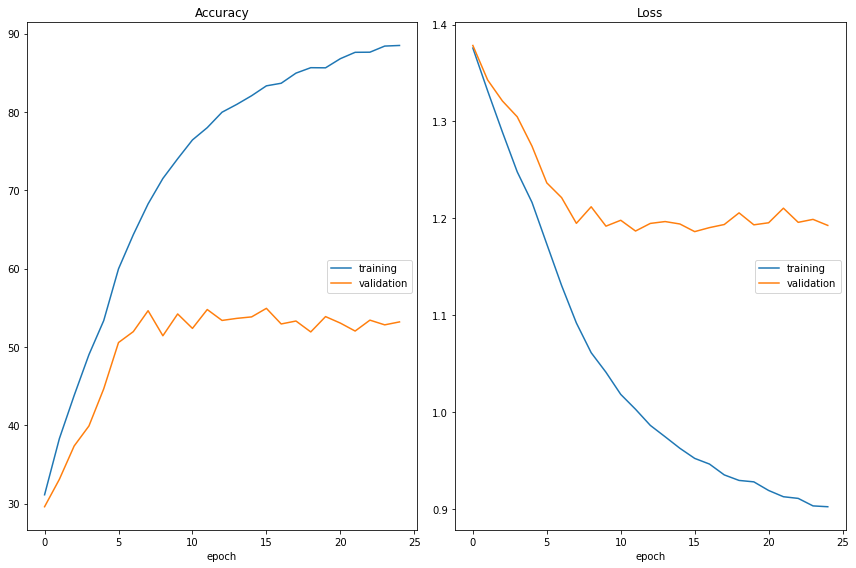

Accuracy
	training         	 (min:   31.135, max:   88.479, cur:   88.479)
	validation       	 (min:   29.609, max:   54.929, cur:   53.198)
Loss
	training         	 (min:    0.903, max:    1.376, cur:    0.903)
	validation       	 (min:    1.186, max:    1.378, cur:    1.193)


In [ ]:
#********************** TRAIN AND SAVE MODEL ******************************#
model=train_model(model, optimizer, num_epochs=25)


In [ ]:
torch.save(model.state_dict(), 'validator-utsav-lstm-cnn.pt')

In [ ]:
class Validator:
  def __init__(self, model, Generated_samples, labels):
    self.model = model
    self.X = Generated_samples
    self.y = labels

    self.test_acc = 0.0
  
  def calculate_val_acc(self):
    outputs = self.model(self.X)
   
    _, predicted = torch.max(outputs, 1)
    print('*****')
    predicted = predicted.view(-1, 1)
    total = predicted.size(0) * predicted.size(1)
    print(predicted)
    print(predicted == self.y)
    correct = (predicted == self.y).sum().item()
    print(correct)
    self.test_acc = (correct / total)
    print(self.test_acc)
